# ViT model building

This notebook will be building a vision transformer to be trained on encrypted images it will be divided into tow sections:
1. Section 1: model building and training on the original images it will be divided into 4 subsections
* Reading the data from google drive
* verifying that the data contains three classes each one having 1000 samples
* using the `timm` module to use a `ViT` model
* Building a baseline
2. Section 2: model building on encrypted images:
* Encrypting the read data
* using the same model as the prevouis step but with a slight verifcation the classes will be divided into three sections one for training one for validation and another one for testing the testing data will be further split into k-folds the validation will be tested on accuracy then the testing will be done on tha layer before the last for feature extraction

## Section 1 Plaintext model fine-tuning

### 1.1 Getting the data from Google Drive and verifying it contains 3 classes and each class has 100 validation samples, 100 testing samples and 1000 training samples

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!mkdir data
!unzip drive/MyDrive/Bustati/potato.zip -d data

Archive:  drive/MyDrive/Bustati/potato.zip
   creating: data/train/
   creating: data/train/bone/
  inflating: data/train/bone/1436.png  
  inflating: data/train/bone/11677.png  
  inflating: data/train/bone/7883.png  
  inflating: data/train/bone/7295.png  
  inflating: data/train/bone/14109.png  
  inflating: data/train/bone/11574.png  
  inflating: data/train/bone/15107.png  
  inflating: data/train/bone/14285.png  
  inflating: data/train/bone/9157.png  
  inflating: data/train/bone/10960.png  
  inflating: data/train/bone/2373.png  
  inflating: data/train/bone/3567.png  
  inflating: data/train/bone/2298.png  
  inflating: data/train/bone/11539.png  
  inflating: data/train/bone/2819.png  
  inflating: data/train/bone/13546.png  
  inflating: data/train/bone/10685.png  
  inflating: data/train/bone/3654.png  
  inflating: data/train/bone/14712.png  
  inflating: data/train/bone/5273.png  
  inflating: data/train/bone/6981.png  
  inflating: data/train/bone/3343.png  
  inflating:

In [ ]:
import os

for dir, subdir, files in os.walk("/content/data/"):
    print(f"{dir} with files {len(files)}")

/content/data/ with files 0
/content/data/valid with files 0
/content/data/valid/chest with files 100
/content/data/valid/bone with files 100
/content/data/valid/mri with files 100
/content/data/train with files 0
/content/data/train/chest with files 1000
/content/data/train/bone with files 1000
/content/data/train/mri with files 1000
/content/data/test with files 0
/content/data/test/chest with files 100
/content/data/test/bone with files 100
/content/data/test/mri with files 100


In [ ]:
try :
    import timm

except ModuleNotFoundError:
    !pip install timm
    import timm

try:
    from torchmetrics import Accuracy

except ModuleNotFoundError:
    !pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.3 MB/s eta 0:00:00


### 1.2 Loading the data and converting it to PyTorch `DataLoader` and getting the model ready in order to use the original transforms

In [ ]:
import timm
import torch
from pathlib import Path
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

model = timm.create_model("vgg16",pretrained=True,num_classes=3)
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)

data_path = Path("/content/data")
train_path = data_path/"train"
test_path = data_path/"valid"
train_data = ImageFolder(
    train_path,
    transform=transform,
)

test_data = ImageFolder(
    test_path,
    transform=transform,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [ ]:
class_to_idx = test_data.class_to_idx
classes = test_data.classes

### 1.3 Building a training and testing loops

In [ ]:
import torchmetrics
import datetime
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
import torch

def train_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,optim:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    model=model.to(device)
    metric = metric.to(device)
    for X,y in dataloader:
        optim.zero_grad()
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        y_probs = y_logits.softmax(axis=1)
        y_preds = y_probs.argmax(axis=1)
        loss = loss_fn(y_logits,y)
        acc = metric(y_preds,y)
        train_loss += loss
        train_acc += acc
        loss.backward()
        optim.step()

    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    return train_loss,train_acc

def test_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
              metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a test step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """

    model.eval()
    model = model.to(device)
    metric = metric.to(device)
    with torch.inference_mode():
        test_loss = 0.0
        test_acc = 0.0
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            y_logits = model(X)
            y_probs = y_logits.softmax(axis=1)
            y_preds = y_probs.argmax(axis=1)
            loss = loss_fn(y_logits,y)
            acc = metric(y_preds,y)
            test_loss += loss.item()
            test_acc += acc.item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)


    return test_loss,test_acc

def train(model:timm.models.vision_transformer.VisionTransformer,
         train_dataloader:torch.utils.data.DataLoader,optim:torch.optim.Optimizer,
         test_dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
          metric:torchmetrics.Accuracy,device:torch.device,epochs:int,
          save_path,writer)->Dict[str,List[float]]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        train_dataloader: the train data loader
        test_dataloader: the test data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training
        epochs: the number of epochs
        save_path: the path of the weights
        writer a tensorboard writer

    Returns:
        A dictionary contiaing the results of experiment
    """
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    if not(save_path.endswith(".pth")):
        save_path = save_path+"best_results.pth"
    training_start_time = datetime.datetime.now()
    best_acc = 0.0
    for epoch in tqdm(range(epochs),desc="Training process"):
        train_loss,train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            optim=optim,
            loss_fn=loss_fn,
            metric=metric,
            device=device
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        test_loss,test_acc = test_step(
            model = model,
            dataloader=test_dataloader,
            loss_fn = loss_fn,
            metric=metric,
            device=device
        )
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if test_acc>best_acc:
            print(f"[INFO] The accuracy has improved in epoch:{epoch} saving the model ...")
            model = model.to("cpu")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
            # Add other relevant information
                }, save_path)

            best_acc = test_acc
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={
                                   "train_loss":train_loss,
                                   "test_loss":test_loss
                               },
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={
                                   "train_acc":train_acc,
                                   "test_acc":test_acc
                               },
                               global_step=epoch)

            writer.add_graph(model=model.to(device),
                             input_to_model=torch.randn(1,3,224,224).to(device))

            writer.close()
    total_time = datetime.datetime.now()-training_start_time
    total_time = total_time.total_seconds()
    if total_time>3600:
        total_time/=3600
        print(f"{total_time} hours for training")
    elif total_time>60:
        total_time/=60
        print(f"{total_time} minutes for training")
    else:
        print(f"{total_time} seconds for training")

    return results


In [ ]:
def plot_losses(results_dict):
  plt.figure(figsize=(10,8))
  if results_dict["train_loss"][0].device !="cpu":
    train_loss = [t.cpu().detach().numpy() for t in results_dict["train_loss"]]
    train_acc = [t.cpu().detach().numpy() for t in results_dict["train_acc"]]

  else :
    train_loss = results_dict["train_loss"]
    train_acc = results_dict["train_acc"]
  plt.subplot(1,2,1)
  plt.plot(train_loss,label="train loss")
  plt.plot(results_dict["test_loss"],label="test loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(train_acc,label="train acc")
  plt.plot(results_dict["test_acc"],label="test acc")
  plt.legend()
  plt.show()


### 1.4 Fitting plaintext data

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
import os
EPOCHS = 100
optim = torch.optim.Adam(params=model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter("/content/drive/MyDrive/Bustati/vgg_plaintext")
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = Accuracy(task="multiclass",num_classes=3)
save_path = "/content/drive/MyDrive/Bustati/vgg16_plaintext.pth"
results_dict = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optim=optim,
    loss_fn=loss_fn,
    metric=metric,
    device=device,
    epochs=EPOCHS,
    save_path=save_path,
    writer=writer

)

Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] The accuracy has improved in epoch:0 saving the model ...


/usr/local/lib/python3.10/dist-packages/timm/models/vgg.py:54: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[-2] < self.input_kernel_size or x.shape[-1] < self.input_kernel_size:


[INFO] The accuracy has improved in epoch:1 saving the model ...
[INFO] The accuracy has improved in epoch:2 saving the model ...
[INFO] The accuracy has improved in epoch:27 saving the model ...
[INFO] The accuracy has improved in epoch:47 saving the model ...
[INFO] The accuracy has improved in epoch:58 saving the model ...
2.1213802088888887 hours for training


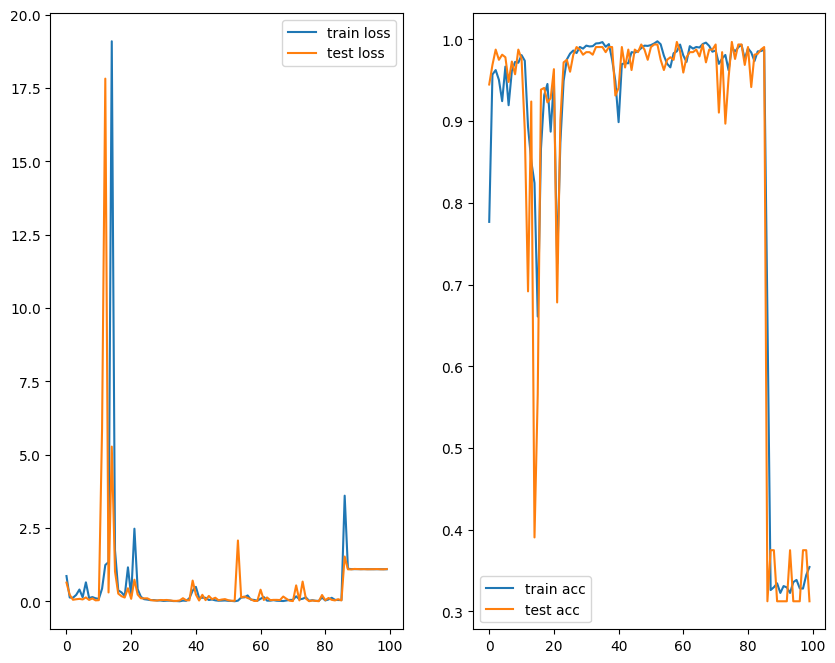

In [ ]:
import matplotlib.pyplot as plt

plot_losses(results_dict)


## Section 2 Encrypted data fine-tuning

### 2.1 Building the transforms (preprocesor)  

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
from torchvision import transforms

class ImageEncryption:
    """
    Class for image encryption using a combination of intra-block texture encryption
    and color encryption.

    Args:
        m (int): The number of subblocks in each dimension.

    Attributes:
        m (int): The number of subblocks in each dimension.

    Methods:
        image_encryption(image_path):
            Encrypts an image using intra-block texture encryption and color encryption.

        intrablock_texture_encryption(subblock):
            Encrypts a subblock using intra-block texture encryption.

        color_encryption(subblock, i):
            Encrypts a subblock using color encryption.
    """
    def __init__(self, m):
        """
        Initializes the ImageEncryption object.

        Args:
            m (int): The number of subblocks in each dimension.
        """
        self.m = m

    def image_encryption(self, image_path):
        """
        Encrypts an image using intra-block texture encryption and color encryption.

        Args:
            image_path (str): The path to the input image file.

        Returns:
            tuple: A tuple containing the encrypted image, image subkeys, and block keys.
        """
        # Load image using cv2.imread
        open_cv_image = np.array(image_path)
        # Convert RGB to BGR
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        img = cv2.resize(open_cv_image,(224,224))
        height, width = img.shape[:2]  # Get height and width using img.shape
        w_subblock = width // self.m
        h_subblock = height // self.m

        image_subblocks = []
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                subblock = img[y1:y2, x1:x2]  # Crop using array slicing
                image_subblocks.append(subblock)

        encrypted_image_subblocks = []
        key_image_subblocks = []
        for subblock in image_subblocks:
            encrypted_subblock, subK = self.intrablock_texture_encryption(np.array(subblock))
            encrypted_image_subblocks.append(encrypted_subblock)
            key_image_subblocks.append(subK)

        img_sub_key = np.empty(len(encrypted_image_subblocks))
        for i in range(len(encrypted_image_subblocks)-1, -1, -1):
            n = random.randint(0, i)
            encrypted_image_subblocks[i], encrypted_image_subblocks[n] = encrypted_image_subblocks[n], encrypted_image_subblocks[i]
            key_image_subblocks[i], key_image_subblocks[n] = key_image_subblocks[n], key_image_subblocks[i]
            img_sub_key[i] = n

        for i in range(len(encrypted_image_subblocks)):
            encrypted_image_subblocks[i] = self.color_encryption(encrypted_image_subblocks[i], i)

        original_image = np.zeros((height, width, 3))
        for i in range(self.m):
            for j in range(self.m):
                x1 = i * w_subblock
                y1 = j * h_subblock
                x2 = x1 + w_subblock
                y2 = y1 + h_subblock
                original_image[y1:y2, x1:x2] = encrypted_image_subblocks[i * self.m + j]
        encrypted_image_subblocks = original_image

        return encrypted_image_subblocks.astype(np.uint8), img_sub_key, key_image_subblocks

    def intrablock_texture_encryption(self, subblock):
        """
        Encrypts a subblock using intra-block texture encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.

        Returns:
            tuple: A tuple containing the encrypted subblock and a dictionary of subkeys.
        """
        lr, lg, lb = cv2.split(subblock)

        # Flatten the color channels
        lr_flat = lr.flatten()
        lg_flat = lg.flatten()
        lb_flat = lb.flatten()

        # Initialize empty key lists for each channel
        sub_img_r_key = np.empty(lr_flat.shape)
        sub_img_g_key = np.empty(lr_flat.shape)
        sub_img_b_key = np.empty(lr_flat.shape)

        # Random shuffling with key generation
        for i in range(len(lb_flat)-1, -1, -1):
            r = random.randint(0, i)
            sub_img_r_key[i] = r
            g = random.randint(0, i)
            sub_img_g_key[i] = g
            b = random.randint(0, i)
            sub_img_b_key[i] = b

            lr_flat[i], lr_flat[r] = lr_flat[r], lr_flat[i]
            lg_flat[i], lg_flat[g] = lg_flat[g], lg_flat[i]
            lb_flat[i], lb_flat[b] = lb_flat[b], lb_flat[i]

        # Reshape flattened arrays to original shape
        lr_flat = lr_flat.reshape(lr.shape)
        lg_flat = lg_flat.reshape(lg.shape)
        lb_flat = lb_flat.reshape(lb.shape)

        # Merge that to become an RGB image
        encrypted_subblock = cv2.merge((lr_flat, lg_flat, lb_flat))

        # Create subK dictionary to store keys
        subK = {
            "sub_img_r_key": sub_img_r_key,
            "sub_img_g_key": sub_img_g_key,
            "sub_img_b_key": sub_img_b_key
        }
        return encrypted_subblock, subK

    def color_encryption(self, subblock, i):
        """
        Encrypts a subblock using color encryption.

        Args:
            subblock (numpy.ndarray): The input subblock to be encrypted.
            i (int): An index used in the encryption process.

        Returns:
            numpy.ndarray: The encrypted subblock.
        """
        er, eg, eb = cv2.split(subblock)
        er_flat = er.flatten()
        eg_flat = eg.flatten()
        eb_flat = eb.flatten()

        eb_flat_ = np.asarray([(e + i / self.m * 256 / self.m) % 256 for e in er_flat]).astype(int)
        er_flat_ = np.asarray([(e + (i % self.m) * 256 / self.m) % 256 for e in eg_flat]).astype(int)
        eg_flat_ = np.asarray([(e + (i / self.m + i % self.m) * 128 / self.m) % 256 for e in eb_flat]).astype(int)

        er_flat_ = er_flat_.reshape(er.shape)
        eg_flat_ = eg_flat_.reshape(eg.shape)
        eb_flat_ = eb_flat_.reshape(eb.shape)

        encrypted_subblock = cv2.merge((er_flat_, eg_flat_, eb_flat_))

        return encrypted_subblock.astype(np.uint8)


class ImageEncryptionTransform(object):
    def __init__(self, m):
        super().__init__()
        self.m = m
        self.image_encryption = ImageEncryption(m)  # Create an instance of your class

    def __call__(self, img):
        # Process the image using the image_encryption object
        encrypted_img, _, _ = self.image_encryption.image_encryption(img)
        encrypted_img = encrypted_img.astype(np.float32)
        encrypted_img/=255.0
        encrypted_img = torch.from_numpy(encrypted_img)
        return encrypted_img.permute(2,0,1)


In [ ]:
import torchmetrics
import datetime
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
import torch
import timm
import torch
from pathlib import Path
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

def train_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,optim:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    model=model.to(device)
    metric = metric.to(device)
    for X,y in dataloader:
        optim.zero_grad()
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        y_probs = y_logits.softmax(axis=1)
        y_preds = y_probs.argmax(axis=1)
        loss = loss_fn(y_logits,y)
        acc = metric(y_preds,y)
        train_loss += loss
        train_acc += acc
        loss.backward()
        optim.step()

    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    return train_loss,train_acc

def test_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
              metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a test step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """

    model.eval()
    model = model.to(device)
    metric = metric.to(device)
    with torch.inference_mode():
        test_loss = 0.0
        test_acc = 0.0
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            y_logits = model(X)
            y_probs = y_logits.softmax(axis=1)
            y_preds = y_probs.argmax(axis=1)
            loss = loss_fn(y_logits,y)
            acc = metric(y_preds,y)
            test_loss += loss.item()
            test_acc += acc.item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)


    return test_loss,test_acc

def train(model:timm.models.vision_transformer.VisionTransformer,
         train_path:str,optim:torch.optim.Optimizer,
         test_path:str,loss_fn:torch.nn.Module,transform,
          metric:torchmetrics.Accuracy,device:torch.device,epochs:int,
          save_path,writer)->Dict[str,List[float]]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        train_dataloader: the train data loader
        test_dataloader: the test data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training
        epochs: the number of epochs
        save_path: the path of the weights
        writer a tensorboard writer

    Returns:
        A dictionary contiaing the results of experiment
    """
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    if not(save_path.endswith(".pth")):
        save_path = save_path+"best_results.pth"
    training_start_time = datetime.datetime.now()
    best_acc = 0.0
    for epoch in tqdm(range(epochs),desc="Training process"):
        train_data = ImageFolder(
                        train_path,
                        transform=transform,
                                    )

        test_data = ImageFolder(
                        test_path,
                        transform=transform,
                    )
        train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)
        test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)
        train_loss,train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            optim=optim,
            loss_fn=loss_fn,
            metric=metric,
            device=device
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        test_loss,test_acc = test_step(
            model = model,
            dataloader=test_dataloader,
            loss_fn = loss_fn,
            metric=metric,
            device=device
        )
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if test_acc>best_acc:
            print(f"[INFO] The accuracy has improved in epoch:{epoch} saving the model ...")
            model = model.to("cpu")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
            # Add other relevant information
                }, save_path)

            best_acc = test_acc
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={
                                   "train_loss":train_loss,
                                   "test_loss":test_loss
                               },
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={
                                   "train_acc":train_acc,
                                   "test_acc":test_acc
                               },
                               global_step=epoch)

            writer.add_graph(model=model.to(device),
                             input_to_model=torch.randn(1,3,224,224).to(device))

            writer.close()
    total_time = datetime.datetime.now()-training_start_time
    total_time = total_time.total_seconds()
    if total_time>3600:
        total_time/=3600
        print(f"{total_time} hours for training")
    elif total_time>60:
        total_time/=60
        print(f"{total_time} minutes for training")
    else:
        print(f"{total_time} seconds for training")

    return results


In [ ]:
# from sklearn.model_selection import KFold
# from torch.utils.tensorboard import SummaryWriter
# from torchmetrics import Accuracy
# import os

# set_seeds()

# transform = transforms.Compose([
#     ImageEncryptionTransform(m=8),  # Apply encryption with desired number of subblocks
# ])
# model = timm.create_model("vit_base_patch16_224",pretrained=True,num_classes=3)
# data_path = Path("/content/data")
# train_path = data_path/"train"
# test_path = data_path/"valid"
# train_data = ImageFolder(
#     train_path,
#     transform=transform,
# )

# test_data = ImageFolder(
#     test_path,
#     transform=transform,
# )


# EPOCHS = 100
# optim = torch.optim.Adam(params=model.parameters(),lr=0.001)
# loss_fn = nn.CrossEntropyLoss()
# writer = SummaryWriter(log_dir="encrypted_run_64_block")
# train_dataloader = DataLoader(train_data,
#                               batch_size=32,
#                               num_workers=os.cpu_count(),
#                               shuffle=True)
# test_dataloader = DataLoader(test_data,
#                              batch_size=32,
#                              num_workers=os.cpu_count(),
#                              shuffle=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# metric = Accuracy(task="multiclass",num_classes=3)
# save_path = "/content/best_model_encrypted_64_block.pth"


# def kfold_cross_validation(model, data, optim, loss_fn, metric, device, epochs, save_path, writer, k=5):
#     results_list = []  # List to store results for each fold

#     kf = KFold(n_splits=k, shuffle=True, random_state=42)

#     for fold, (train_index, val_index) in enumerate(kf.split(data)):
#         # Create data loaders for current fold
#         train_dataset = torch.utils.data.Subset(data, train_index)
#         val_dataset = torch.utils.data.Subset(data, val_index)

#         train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
#         val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

#         # Initialize model, optimizer, etc. (if needed) for each fold
#         model = model
#         optim = optim

#         # Train the model for the current fold
#         results_dict = train(
#             model=model,
#             train_dataloader=train_dataloader,
#             test_dataloader=val_dataloader,  # Use validation data for testing in this case
#             optim=optim,
#             loss_fn=loss_fn,
#             metric=metric,
#             device=device,
#             epochs=epochs,
#             save_path=save_path,
#             writer=writer
#         )

#         results_list.append(results_dict)

#     return results_list
# # Example usage
# results_list = kfold_cross_validation(
#     model=model,
#     data=train_data,  # Assuming train_data is the complete dataset
#     optim=optim,
#     loss_fn=loss_fn,
#     metric=metric,
#     device=device,
#     epochs=EPOCHS,
#     save_path=save_path,
#     writer=writer,
#     k=5  # You can adjust the number of folds as needed
# )

# # Print or analyze results for each fold
# for fold, results_dict in enumerate(results_list):
#     print(f"Fold {fold + 1} Results:")
#     print(f"Train Loss: {results_dict['train_loss'][-1]}, Train Acc: {results_dict['train_acc'][-1]}")
#     print(f"Test Loss: {results_dict['test_loss'][-1]}, Test Acc: {results_dict['test_acc'][-1]}")
#     print()


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
import os
EPOCHS = 100
set_seeds()
optim = torch.optim.Adam(params=model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir="/content/drive/MyDrive/Bustati/one_block_vit")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = Accuracy(task="multiclass",num_classes=3)

transform = transforms.Compose([
    ImageEncryptionTransform(m=1),  # Apply encryption with desired number of subblocks
])
model = timm.create_model("vit_base_patch16_224",pretrained=True,num_classes=3)
data_path = Path("/content/data")
train_path = data_path/"train"
test_path = data_path/"valid"
save_path = "/content/drive/MyDrive/Bustati/one_block_vit.pth"
results_dict = train(
    model=model,
    train_path=train_path,
    test_path=test_path,
    optim=optim,
    loss_fn=loss_fn,
    metric=metric,
    device=device,
    epochs=EPOCHS,
    transform=transform,
    save_path=save_path,
    writer=writer

)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] The accuracy has improved in epoch:0 saving the model ...


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1404: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


[INFO] The accuracy has improved in epoch:1 saving the model ...
[INFO] The accuracy has improved in epoch:30 saving the model ...
[INFO] The accuracy has improved in epoch:38 saving the model ...
[INFO] The accuracy has improved in epoch:46 saving the model ...
[INFO] The accuracy has improved in epoch:66 saving the model ...
12.583129154444444 hours for training


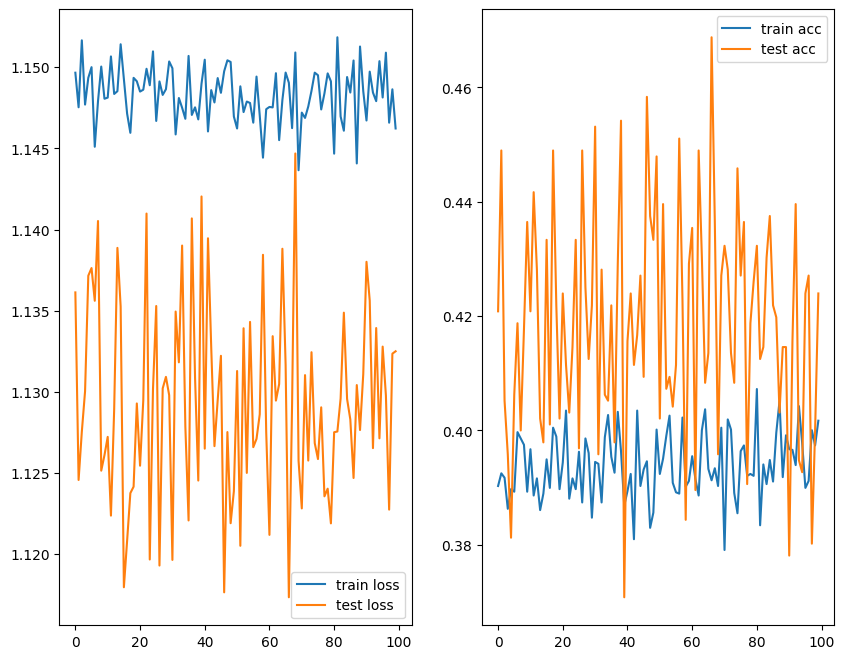

In [ ]:
plot_losses(results_dict)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
import os
model = timm.create_model('vgg16',pretrained=True,num_classes=3)
EPOCHS = 100
set_seeds()
optim = torch.optim.Adam(params=model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir="/content/drive/MyDrive/Bustati/one_block_vgg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = Accuracy(task="multiclass",num_classes=3)

transform = transforms.Compose([
    ImageEncryptionTransform(m=8),  # Apply encryption with desired number of subblocks
])
# model = timm.create_model("vit_base_patch16_224",pretrained=True,num_classes=3)
data_path = Path("/content/data")
train_path = data_path/"train"
test_path = data_path/"valid"
save_path = "/content/drive/MyDrive/Bustati/one_block_vgg.pth"
results_dict = train(
    model=model,
    train_path=train_path,
    test_path=test_path,
    optim=optim,
    loss_fn=loss_fn,
    metric=metric,
    device=device,
    epochs=EPOCHS,
    transform=transform,
    save_path=save_path,
    writer=writer

)

Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] The accuracy has improved in epoch:0 saving the model ...


/usr/local/lib/python3.10/dist-packages/timm/models/vgg.py:54: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[-2] < self.input_kernel_size or x.shape[-1] < self.input_kernel_size:


[INFO] The accuracy has improved in epoch:1 saving the model ...
[INFO] The accuracy has improved in epoch:2 saving the model ...
[INFO] The accuracy has improved in epoch:3 saving the model ...
[INFO] The accuracy has improved in epoch:4 saving the model ...
[INFO] The accuracy has improved in epoch:5 saving the model ...
[INFO] The accuracy has improved in epoch:11 saving the model ...
[INFO] The accuracy has improved in epoch:21 saving the model ...
[INFO] The accuracy has improved in epoch:23 saving the model ...
[INFO] The accuracy has improved in epoch:26 saving the model ...
[INFO] The accuracy has improved in epoch:30 saving the model ...
[INFO] The accuracy has improved in epoch:31 saving the model ...
[INFO] The accuracy has improved in epoch:38 saving the model ...
[INFO] The accuracy has improved in epoch:40 saving the model ...
11.805620237222223 hours for training


In [ ]:
plot_losses(results_dict)

NameError: name 'plot_losses' is not defined

## **ONN**

In [ ]:
!rm -rf /content/drive/MyDrive/Bustati/onn_vgg

In [ ]:
!pip install git+https://github.com/junaidmalik09/fastonn.git

  Cloning https://github.com/junaidmalik09/fastonn.git to /tmp/pip-req-build-p9gwz1cd
  Running command git clone --filter=blob:none --quiet https://github.com/junaidmalik09/fastonn.git /tmp/pip-req-build-p9gwz1cd
  Resolved https://github.com/junaidmalik09/fastonn.git to commit ff9d9935e3f2493e6b59962f677081e9c8bc3e87
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299577 sha256=525d50861357fad94be4dfb92839c3ceadd75a3b45bbd0d2167ef55691a032ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-e3u_kebn/wheels/34/bf/3d/75c9a3df86d662f414c5ebd27dc3347ef61724c11782395dd8
Successfully built fastonn


In [ ]:
!git clone https://github.com/junaidmalik09/fastonn.git

Cloning into 'fastonn'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 171 (delta 30), reused 71 (delta 11), pack-reused 70
Receiving objects: 100% (171/171), 555.71 KiB | 16.34 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
# get the files of VLPSO
import sys
from fastonn.osl import *
from fastonn.utils import *
from fastonn import OpNetwork,utils,OpTier,OpBlock,Trainer
from fastonn.utils import get_dataset_with_folds,ONNDataset


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

In [ ]:
sys.path.insert(0,'/content/fastonn')

In [ ]:
nodal = [mul,cubic,sine,expp,sinh,sinc2.apply,chirp]
act = [tanh,lincut]
pool = [summ]
OPLIB = getOPLIB(nodal,pool,act)

In [ ]:
def save_weights_callback(model, filename):
    torch.save(model.state_dict(), filename)

In [ ]:

def fit(r,e, optim, filename):
        acc = []
        loss = []

        batches = Train_dataloader

        # Fit all training data
        with tqdm(total=len(batches)) as pbar:

          for inputs, labels in batches:
            # Forward propagate
            pbar.update()
            i=inputs.to('cuda') # Input

            g=labels.to('cuda') # GT
            o = model(i) # Output

            # Calculate loss
            l = F.cross_entropy(o.cpu(), g.cpu())

            # Backpropagation
            l.backward()  # Backpropagate loss

            optim.step()  # Update
            optim.zero_grad()  # Reset gradients

            # Track accuracy and loss
            acc.append(accuracy_score(g.cpu(), o.argmax(1).cpu()))
            loss.append(l)
            save_weights_callback(model, filename)


          mean_acc = sum(acc) / len(acc)
          mean_loss = sum(loss) / len(loss)
        # Print accuracy and loss for each epoch
          print(f" ... Epoch {e + 1}, accuracy: {mean_acc:.4f}, loss: {mean_loss:.4f}")
          return mean_acc, mean_loss


In [ ]:
def train(model, optim, file_name, num_epochs=50,num_runs=1):
        history = {}
        history['loss'] = []
        history['acc'] = []


        # Initialize Statistics
        model.to('cuda') # just in case
       # init_stats(num_epochs,num_runs)
        runs = range(num_runs)
       # if verbose>0: runs = tqdm(runs,desc='Run')
        for r in runs:
            r = r
            model.apply(reset_function_generic)
            model.to('cuda')
            optimizer =  torch.optim.SGD(model.parameters(),lr=0.001) #get_optimizer(model,opt_name,lr)

            epochs = range(num_epochs)
            #if verbose>1: epochs = tqdm(epochs,desc='Epoch')
            for e in epochs:
                e = e
                mean_acc, mean_loss = fit(r,e, optim, file_name) # training
                history['loss'].append(mean_loss)
                history['acc'].append(mean_acc)

               # evaluate(r,e,pbar=epochs,modes=['train','val'])
               # if hasattr(optimizer,'setLR'): optimizer.setLR(torch.mean(stats['train']['loss'][r][e]))

            #evaluate(r,e,runs,modes=['train','val','test'])

        # print('\n\n')
        return history

In [ ]:
import torchmetrics
import datetime
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
import torch
import timm
import torch
from pathlib import Path
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

def train_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,optim:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """
    train_acc = 0.0
    train_loss = 0.0
    model.train()


    model=model.to(device)
    metric = metric.to(device)
    for X,y in tqdm(dataloader):
        optim.zero_grad()
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        y_probs = y_logits.softmax(axis=1)
        y_preds = y_probs.argmax(axis=1)
        loss = loss_fn(y_logits,y)
        acc = metric(y_preds,y)
        train_loss += loss
        train_acc += acc
        loss.backward()
        optim.step()

    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    return train_loss,train_acc

def test_step(model:timm.models.vision_transformer.VisionTransformer,
               dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,
              metric:torchmetrics.Accuracy
               ,device:torch.device)->Tuple[float,float]:
    """
    Performs a test step on the model

    Args:
        model: a vision transfomer model
        dataloader: the train data loader
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training

    Returns:
        a tuple of floats the first is the loss and the second is the accuracy
    """

    model.eval()
    model = model.to(device)
    metric = metric.to(device)
    with torch.inference_mode():
        test_loss = 0.0
        test_acc = 0.0
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            y_logits = model(X)
            y_probs = y_logits.softmax(axis=1)
            y_preds = y_probs.argmax(axis=1)
            loss = loss_fn(y_logits,y)
            acc = metric(y_preds,y)
            test_loss += loss.item()
            test_acc += acc.item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)


    return test_loss,test_acc

def train(model:timm.models.vision_transformer.VisionTransformer,
         train_path:str,optim:torch.optim.Optimizer,
         test_path:str,loss_fn:torch.nn.Module,transform,
          metric:torchmetrics.Accuracy,device:torch.device,epochs:int,
          save_path,writer)->Dict[str,List[float]]:
    """
    Performs a training step on the model

    Args:
        model: a vision transfomer model
        train_dataloader: the train data loader
        test_dataloader: the test data loader
        optim: optimizer
        loss_fn: loss function
        metric: the metrics to be measured
        device: the device of training
        epochs: the number of epochs
        save_path: the path of the weights
        writer a tensorboard writer

    Returns:
        A dictionary contiaing the results of experiment
    """
    results ={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    if not(save_path.endswith(".pth")):
        save_path = save_path+"best_results.pth"
    training_start_time = datetime.datetime.now()
    best_acc = 0.0
    for epoch in tqdm(range(epochs),desc="Training process"):
        train_data = ImageFolder(
                        train_path,
                        transform=transform,
                                    )

        test_data = ImageFolder(
                        test_path,
                        transform=transform,
                    )
        train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)
        test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)
        train_loss,train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            optim=optim,
            loss_fn=loss_fn,
            metric=metric,
            device=device
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        test_loss,test_acc = test_step(
            model = model,
            dataloader=test_dataloader,
            loss_fn = loss_fn,
            metric=metric,
            device=device
        )
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        if test_acc>best_acc:
            print(f"[INFO] The accuracy has improved in epoch:{epoch} saving the model ...")
            model = model.to("cpu")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
            # Add other relevant information
                }, save_path)

            best_acc = test_acc
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={
                                   "train_loss":train_loss,
                                   "test_loss":test_loss
                               },
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={
                                   "train_acc":train_acc,
                                   "test_acc":test_acc
                               },
                               global_step=epoch)

            writer.add_graph(model=model.to(device),
                             input_to_model=torch.randn(1,3,224,224).to(device))

            writer.close()
    total_time = datetime.datetime.now()-training_start_time
    total_time = total_time.total_seconds()
    if total_time>3600:
        total_time/=3600
        print(f"{total_time} hours for training")
    elif total_time>60:
        total_time/=60
        print(f"{total_time} minutes for training")
    else:
        print(f"{total_time} seconds for training")

    return results


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
import os

onnmodel = timm.create_model('vgg16',pretrained=True,num_classes=3)

in_channels=3
tier_sizes=[3,16,3]
kernel_sizes=[21,3,16]
operators=[[1],[3],[6]]
sampling_factors=[2,-2,1]
OPLIB=OPLIB
pad=-1

for i in range(len(tier_sizes)):
  if i==0: onnmodel.add_module(str(i),OpTier(in_channels,tier_sizes[i],kernel_sizes[i],operators[i],OPLIB))
  else: onnmodel.add_module(str(i),OpTier(tier_sizes[i-1],tier_sizes[i],kernel_sizes[i],operators[i],OPLIB))

onnmodel.add_module('flatten final', nn.Flatten())
onnmodel.add_module('classifier final', nn.Linear(tier_sizes[-1] * 224*224, 3))


EPOCHS = 100
set_seeds()
onnmodel.apply(reset_function_generic)
optim = torch.optim.Adam(params=onnmodel.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir="/content/drive/MyDrive/Bustati/onn_vgg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = Accuracy(task="multiclass",num_classes=3)

transform = transforms.Compose([
    ImageEncryptionTransform(m=8),  # Apply encryption with desired number of subblocks
])
# model = timm.create_model("vit_base_patch16_224",pretrained=True,num_classes=3)
data_path = Path("/content/data")
train_path = data_path/"train"
test_path = data_path/"valid"
save_path = "/content/drive/MyDrive/Bustati/onn_vgg.pth"
results_dict = train(
    model=onnmodel,
    train_path=train_path,
    test_path=test_path,
    optim=optim,
    loss_fn=loss_fn,
    metric=metric,
    device=device,
    epochs=EPOCHS,
    transform=transform,
    save_path=save_path,
    writer=writer

)

Training process:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[INFO] The accuracy has improved in epoch:0 saving the model ...


/usr/local/lib/python3.10/dist-packages/timm/models/vgg.py:54: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[-2] < self.input_kernel_size or x.shape[-1] < self.input_kernel_size:


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
    Traceback (most recent call last):
Exception ignored in: self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  0%|          | 0/94 [00:00<?, ?it/s]

[INFO] The accuracy has improved in epoch:2 saving the model ...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):

Traceback (most recent call last):
Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
    Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Exception ignored in: 
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__



    

self._shutdown_workers()Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-pac

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

            Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>AssertionErrorException ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>: can only test a child process
Exception ignored in: Traceback (most recent call last):
<fun

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Exception ignored in: 
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
    Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del_

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>

Traceback (most recent call last):
Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
    Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent ca

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>    Exception ignored in: Traceback (most recent call last):
self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shu

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Exception ignored in: 
Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a8b67dcaf0>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x

  0%|          | 0/94 [00:00<?, ?it/s]

14.665868170833335 hours for training
